In [86]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("azminetoushikwasi/supplygraph-supply-chain-planning-using-gnns")

# print("Path to dataset files:", path)

In [87]:
import pandas as pd
path = "./supplygraph-supply-chain-planning-using-gnns/versions/2/Raw Dataset/"

# Nodes
nodes = pd.read_csv(path + "Nodes/Nodes.csv")   
edges = pd.read_csv(path + "Edges/Edges (Plant).csv")

delivery_to_distributor = pd.read_csv(path + "Temporal Data/Unit/Delivery To distributor.csv")
factory_issue = pd.read_csv(path + "Temporal Data/Unit/factory issue.csv")
production = pd.read_csv(path + "Temporal Data/Unit/Production .csv")
sales_order = pd.read_csv(path + "Temporal Data/Unit/Sales order.csv")

In [88]:
import pandas as pd
import numpy as np
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

path = "./supplygraph-supply-chain-planning-using-gnns/versions/2/Raw Dataset/Temporal Data/Unit/"

production = pd.read_csv(path + "Production .csv")
factory_issue = pd.read_csv(path + "factory issue.csv")
delivery = pd.read_csv(path + "Delivery To distributor.csv")
sales_order = pd.read_csv(path + "Sales order.csv")

products = [col for col in production.columns if col != "Date"]
product_to_id = {prod: i for i, prod in enumerate(products)}

def transform_temporal(df, mapping):
    df_no_date = df.drop(columns=["Date"])
    return df_no_date.rename(columns=mapping)

X_prod = transform_temporal(production, product_to_id)
X_issue = transform_temporal(factory_issue, product_to_id)
X_delivery = transform_temporal(delivery, product_to_id)
X_sales = transform_temporal(sales_order, product_to_id)  

X_prod_np = X_prod.to_numpy()
X_issue_np = X_issue.to_numpy()
X_delivery_np = X_delivery.to_numpy()
X_sales_np = X_sales.to_numpy()

# shape: [T, N, F] = [time_steps, num_nodes, num_features]
X = np.stack([X_prod_np, X_issue_np, X_delivery_np, X_sales_np], axis=-1)

y = X_sales_np[1:]       
X = X[:-1]

print("X shape:", X.shape)  # (T-1, N, 4)
print("y shape:", y.shape)  # (T-1, N)


X shape: (220, 41, 4)
y shape: (220, 41)


In [89]:
# X = X[:150]
# X.shape
# y = y[:150]

In [90]:
train = int(0.8 * X.shape[0])

X_train, X_test = X[:train], X[train:]
y_train, y_test = y[:train], y[train:]

In [91]:
from sklearn.preprocessing import StandardScaler
import numpy as np

T, N, F = X_train.shape

# Prepare scaled containers
X_train_scaled = np.zeros_like(X_train)
y_train_scaled = np.zeros_like(y_train)
X_test_scaled = np.zeros_like(X_test)
y_test_scaled = np.zeros_like(y_test)

scaler_X_per_product = []
scaler_y_per_product = []

for node_idx in range(N):
    # Fit a scaler for features of this product
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_node = X_train[:, node_idx, :]  # (T, F)
    y_node = y_train[:, node_idx].reshape(-1, 1)
    
    X_train_scaled[:, node_idx, :] = scaler_X.fit_transform(X_node)
    y_train_scaled[:, node_idx] = scaler_y.fit_transform(y_node).ravel()
    
    # Scale test data using same scaler
    X_test_scaled[:, node_idx, :] = scaler_X.transform(X_test[:, node_idx, :])
    y_test_scaled[:, node_idx] = scaler_y.transform(y_test[:, node_idx].reshape(-1, 1)).ravel()
    
    scaler_X_per_product.append(scaler_X)
    scaler_y_per_product.append(scaler_y)


In [92]:
edges = pd.read_csv("./supplygraph-supply-chain-planning-using-gnns/versions/2/Raw Dataset/Edges/Edges (Product Group).csv")

edges['node1'] = edges['node1'].astype(str)
edges['node2'] = edges['node2'].astype(str)

edges['node1'] = edges['node1'].map(product_to_id)
edges['node2'] = edges['node2'].map(product_to_id)

edge_index = edges[['node1', 'node2']].to_numpy().T.astype(np.int64)

num_nodes = len(product_to_id)

train_dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=np.ones(edge_index.shape[1]),
    features=X_train_scaled,
    targets=y_train_scaled
)

test_dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=np.ones(edge_index.shape[1]),
    features=X_test_scaled,
    targets=y_test_scaled
)


In [93]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GCLSTM

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, hidden_size=16, num_layers=1):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GCLSTM(node_features, hidden_size, 1)
        self.linear = torch.nn.Linear(hidden_size, 1)

    def forward(self, x, edge_index, edge_weight, h=None, c=None):
        # Pass previous hidden states (if any)
        h, c = self.recurrent(x, edge_index, edge_weight, h, c)
        out = F.relu(h)
        out = self.linear(out)
        return out.squeeze(-1), (h, c)

In [96]:
model = RecurrentGCN(node_features=4, hidden_size=16, num_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [97]:
from tqdm import tqdm

def calculate_mse(model, dataset):
    model.eval()
    total_loss = 0.0
    h, c = None, None
    with torch.no_grad():
        for time, snapshot in enumerate(dataset):
            y_hat, (h, c) = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
            total_loss += torch.mean((y_hat - snapshot.y) ** 2).item()
    return total_loss / (time + 1)


gclstm_train_mse = []
gclstm_test_mse = []

n_epoch = 100

for epoch in tqdm(range(n_epoch)):
    model.train()
    total_loss = 0
    h, c = None, None
    for time, snapshot in enumerate(train_dataset):
        optimizer.zero_grad()
        y_hat, (h, c) = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        loss = torch.mean((y_hat - snapshot.y) ** 2)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        h = h.detach()
        c = c.detach()

    
    train_mse = calculate_mse(model, train_dataset)
    test_mse = calculate_mse(model, test_dataset)
    gclstm_train_mse.append(train_mse)
    gclstm_test_mse.append(test_mse)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epoch} | Train MSE: {train_mse:.4f} | Test MSE: {test_mse:.4f}")



 10%|█         | 10/100 [00:18<02:25,  1.62s/it]

Epoch 10/100 | Train MSE: 0.9532 | Test MSE: 2.3704


 20%|██        | 20/100 [00:37<02:28,  1.85s/it]

Epoch 20/100 | Train MSE: 0.9431 | Test MSE: 2.3630


 30%|███       | 30/100 [00:55<02:03,  1.77s/it]

Epoch 30/100 | Train MSE: 0.9412 | Test MSE: 2.3584


 40%|████      | 40/100 [01:15<02:02,  2.04s/it]

Epoch 40/100 | Train MSE: 0.9350 | Test MSE: 2.3563


 50%|█████     | 50/100 [01:35<01:45,  2.11s/it]

Epoch 50/100 | Train MSE: 0.9307 | Test MSE: 2.3563


 60%|██████    | 60/100 [01:54<01:11,  1.78s/it]

Epoch 60/100 | Train MSE: 0.9243 | Test MSE: 2.3540


 70%|███████   | 70/100 [02:13<01:05,  2.19s/it]

Epoch 70/100 | Train MSE: 0.9189 | Test MSE: 2.3478


 80%|████████  | 80/100 [02:41<00:51,  2.56s/it]

Epoch 80/100 | Train MSE: 0.8921 | Test MSE: 2.3341


 90%|█████████ | 90/100 [03:02<00:18,  1.86s/it]

Epoch 90/100 | Train MSE: 0.8838 | Test MSE: 2.3428


100%|██████████| 100/100 [03:23<00:00,  2.04s/it]

Epoch 100/100 | Train MSE: 0.8851 | Test MSE: 2.3478


In [98]:
# SIMPLE LSTM
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=16, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    
    def forward(self, x, h=None, c=None):
        # x shape: (batch_size, seq_len, input_size)
        out, (h_n, c_n) = self.lstm(x, (h, c)) if h is not None else self.lstm(x)
        predictions = self.linear(out[:, -1, :])
        return predictions.squeeze(-1), (h_n, c_n)

In [99]:
lstm_model = SimpleLSTM(input_size=4, hidden_size=16, num_layers=1)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.MSELoss()

In [100]:
from tqdm import tqdm

def calculate_mse(model, dataset):
    model.eval()
    total_loss = 0.0
    h, c = None, None
    with torch.no_grad():
        for time, snapshot in enumerate(dataset):
            y_hat, (h, c) = model(snapshot.x.unsqueeze(1), h, c)
            total_loss += torch.mean((y_hat - snapshot.y) ** 2).item()
    return total_loss / (time + 1)


lstm_train_losses = []
lstm_test_losses = []

n_epoch = 100

for epoch in tqdm(range(n_epoch)):
    lstm_model.train()
    total_loss = 0
    h, c = None, None
    for time, snapshot in enumerate(train_dataset):

        lstm_optimizer.zero_grad()
        out, (h, c) = lstm_model(snapshot.x.unsqueeze(1), h, c)
        loss = criterion(out, snapshot.y)
        loss.backward()
        lstm_optimizer.step()
        total_loss += loss.item()

        h = h.detach()
        c = c.detach()


    train_mse = calculate_mse(lstm_model, train_dataset)
    test_mse = calculate_mse(lstm_model, test_dataset)
    lstm_train_losses.append(train_mse)
    lstm_test_losses.append(test_mse)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epoch} | Train MSE: {train_mse:.4f} | Test MSE: {test_mse:.4f}")



  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:06<00:53,  1.69it/s]

Epoch 10/100 | Train MSE: 0.9543 | Test MSE: 2.3660


 20%|██        | 20/100 [00:11<00:40,  1.98it/s]

Epoch 20/100 | Train MSE: 0.9485 | Test MSE: 2.3600


 30%|███       | 30/100 [00:16<00:37,  1.88it/s]

Epoch 30/100 | Train MSE: 0.9447 | Test MSE: 2.3617


 40%|████      | 40/100 [00:24<00:37,  1.60it/s]

Epoch 40/100 | Train MSE: 0.9416 | Test MSE: 2.3555


 50%|█████     | 50/100 [00:28<00:22,  2.20it/s]

Epoch 50/100 | Train MSE: 0.9272 | Test MSE: 2.3452


 60%|██████    | 60/100 [00:33<00:18,  2.18it/s]

Epoch 60/100 | Train MSE: 0.9110 | Test MSE: 2.3395


 70%|███████   | 70/100 [00:38<00:13,  2.28it/s]

Epoch 70/100 | Train MSE: 0.9063 | Test MSE: 2.3378


 80%|████████  | 80/100 [00:42<00:09,  2.18it/s]

Epoch 80/100 | Train MSE: 0.9003 | Test MSE: 2.3359


 90%|█████████ | 90/100 [00:47<00:05,  1.90it/s]

Epoch 90/100 | Train MSE: 0.8951 | Test MSE: 2.3335


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]

Epoch 100/100 | Train MSE: 0.8946 | Test MSE: 2.3398


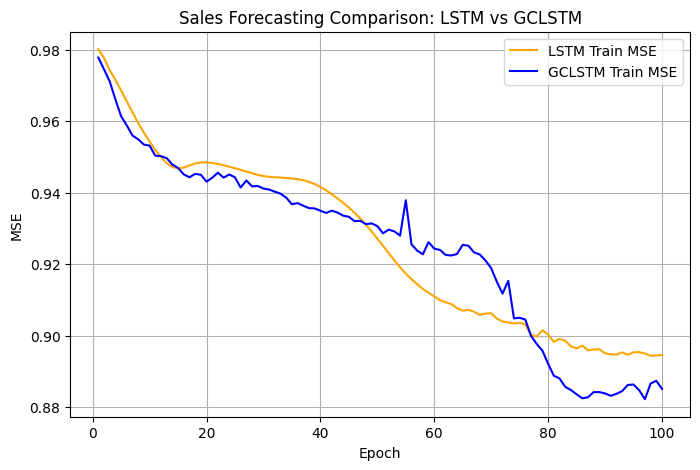

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, n_epoch+1), lstm_train_losses, label="LSTM Train MSE", color="orange")
plt.plot(range(1, n_epoch+1), gclstm_train_mse, label="GCLSTM Train MSE", color="blue")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Sales Forecasting Comparison: LSTM vs GCLSTM")
plt.legend()
plt.grid(True)
plt.show()

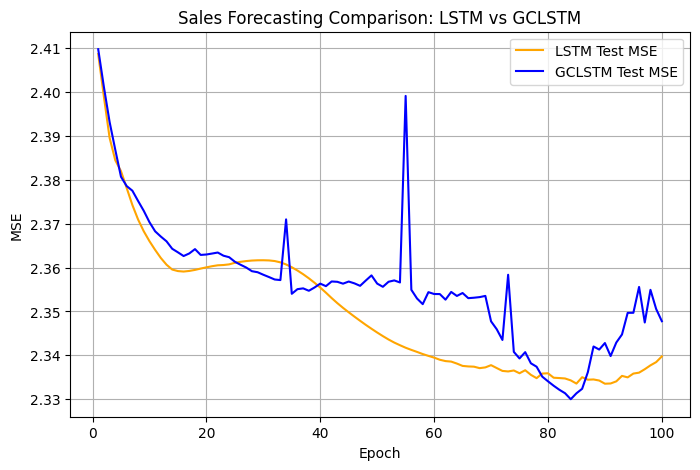

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, n_epoch+1), lstm_test_losses, label="LSTM Test MSE", color="orange")
plt.plot(range(1, n_epoch+1), gclstm_test_mse, label="GCLSTM Test MSE", color="blue")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Sales Forecasting Comparison: LSTM vs GCLSTM")
plt.legend()
plt.grid(True)
plt.show()